In [1]:
import sys
sys.path.insert(0, '../src/')

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import torch
import scipy.sparse as sp
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter
from sklearn.metrics import roc_auc_score, average_precision_score
import time
import pickle
import pandas as pd
%matplotlib inline

from net.utils import *
from net import utils_netgan as utils
import net.net as net

# Run pipeline several times and plot average during training

In [2]:
def main(train_graph, val_ones, val_zeros, H, steps, optimizer_args, log_every, print_every):
    # Apply pipeline to generate a graph with our method
    W = train_graph.toarray()
    W /= W.sum()

    netmodel = net.NetWithoutSampling(W=W, 
                                      H=H, 
                                      loggers=[net.GraphStatisticsLoggerWithoutSampling(train_graph, 
                                                                                        val_ones,
                                                                                        val_zeros,
                                                                                        log_every=log_every),
                                               net.OverlapLoggerWithoutSampling(train_graph, 
                                                                                print_every=print_every)])

    netmodel.train(steps=steps,
                   optimizer_fn=torch.optim.Adam,
                   optimizer_args=optimizer_args)

    transition_matrix = netmodel()

    scores_matrix = scores_matrix_from_transition_matrix(transition_matrix=transition_matrix,
                                                         symmetric=True)
    scores_matrix = sp.csr_matrix(scores_matrix)

    sampled_graph = utils.graph_from_scores(scores_matrix, train_graph.sum())
    statistics_logger = netmodel.loggers[0]
    return sampled_graph, statistics_logger

#### Get graph

In [3]:
_A_obs, _X_obs, _z_obs = utils.load_npz('../data/cora_ml.npz')
_A_obs = _A_obs + _A_obs.T
_A_obs[_A_obs > 1] = 1
lcc = utils.largest_connected_components(_A_obs)
_A_obs = _A_obs[lcc,:][:,lcc]
_N = _A_obs.shape[0]

val_share = 0.1
test_share = 0.05
seed = 481516234

train_ones, val_ones, val_zeros, test_ones, test_zeros = utils.train_val_test_split_adjacency(_A_obs, val_share, test_share, seed, undirected=True, connected=True, asserts=True)

train_graph = sp.coo_matrix((np.ones(len(train_ones)),(train_ones[:,0], train_ones[:,1]))).tocsr()
assert (train_graph.toarray() == train_graph.toarray().T).all()

statistics_train = utils.compute_graph_statistics(train_graph.toarray())

Selecting 1 largest connected components


#### Train K times 

In [4]:
K = 30
statistics_loggers = []

for k in range(K):
    print(f'Step {k}')
    sampled_graph, statistics_logger = main(train_graph=train_graph, val_ones=val_ones,
                                            val_zeros=val_zeros,
                                            H=12, steps=150,
                                            optimizer_args={'lr' : 0.1},
                                            log_every=5,
                                            print_every=50)
    statistics_loggers.append(statistics_logger)
statistics_loggers = [logger() for logger in statistics_loggers]    

Step 0
Step: 49, Loss: 2.35537, Edge-Overlap: 0.778
Step: 99, Loss: 2.15228, Edge-Overlap: 0.887
Step: 149, Loss: 2.10067, Edge-Overlap: 0.925
Step 1
Step: 49, Loss: 2.33909, Edge-Overlap: 0.779
Step: 99, Loss: 2.14053, Edge-Overlap: 0.889
Step: 149, Loss: 2.09928, Edge-Overlap: 0.929
Step 2
Step: 49, Loss: 2.36078, Edge-Overlap: 0.768
Step: 99, Loss: 2.15089, Edge-Overlap: 0.885
Step: 149, Loss: 2.10209, Edge-Overlap: 0.929
Step 3
Step: 49, Loss: 2.35089, Edge-Overlap: 0.768
Step: 99, Loss: 2.14992, Edge-Overlap: 0.888
Step: 149, Loss: 2.10051, Edge-Overlap: 0.929
Step 4
Step: 49, Loss: 2.37424, Edge-Overlap: 0.764
Step: 99, Loss: 2.15497, Edge-Overlap: 0.882
Step: 149, Loss: 2.10313, Edge-Overlap: 0.925
Step 5
Step: 49, Loss: 2.36109, Edge-Overlap: 0.765
Step: 99, Loss: 2.15940, Edge-Overlap: 0.885
Step: 149, Loss: 2.10724, Edge-Overlap: 0.921
Step 6
Step: 49, Loss: 2.36004, Edge-Overlap: 0.761
Step: 99, Loss: 2.14854, Edge-Overlap: 0.886
Step: 149, Loss: 2.09827, Edge-Overlap: 0.925

TypeError: 'GraphStatisticsLoggerWithoutSampling' object is not callable

#### Saving and loading

In [17]:
pickle.dump(statistics_loggers, open("../data/statistics_loggers.p", "wb"))

In [4]:
statistics_loggers = pickle.load(open("../data/statistics_loggers.p", "rb"))

#### Make boxplot

In [5]:
def print_average_statistics(statistics_loggers, statistics_train, keys):
    n_cols, n_rows = get_plot_grid_size(len(keys))
    plt.rcParams.update({'font.size': 18})
    f, axs = plt.subplots(n_rows, n_cols, sharex=True, figsize=(22, 12))
    axs = np.array(axs).reshape(n_rows, n_cols)
    plt.tight_layout(pad=3)
    
    statistics_train['overlap'] = 1
    steps = statistics_loggers[0]['step']
    # Collect statistics in dict of lists of lists of statistics
    dict_of_lists_of_lists_of_statistics = {}
    for statistics in statistics_loggers:
        dict_of_lists_of_lists_of_statistics = update_dict_of_lists(dict_of_lists_of_lists_of_statistics,
                                                                    statistics)
    # Boxplot    
    for row in range(n_rows):
        for col in range(n_cols):
            i = row * n_cols + col
            if i < len(keys):
                key = keys[row * n_cols + col]
                axs[row, col].boxplot(np.array(dict_of_lists_of_lists_of_statistics[key]), positions=steps,
                                      widths=2,
                                      showfliers=False)
                axs[row, col].hlines(y=statistics_train[key],
                                     xmin=steps[0],
                                     xmax=steps[-1],
                                     colors='green',
                                     linestyles='dashed')        
                axs[row, col].yaxis.set_major_formatter(FuncFormatter(y_fmt))
                axs[row, col].set_xlabel('Training iteration', labelpad=5)               
                axs[row, col].set_ylabel(translate_key_for_plot(key), labelpad=2)
            else:
                axs[row, col].axis('off')
    #         plt.savefig('../fig/our_statistics_during_training.pdf', format='pdf')                    
    plt.show()  
    return dict_of_lists_of_lists_of_statistics

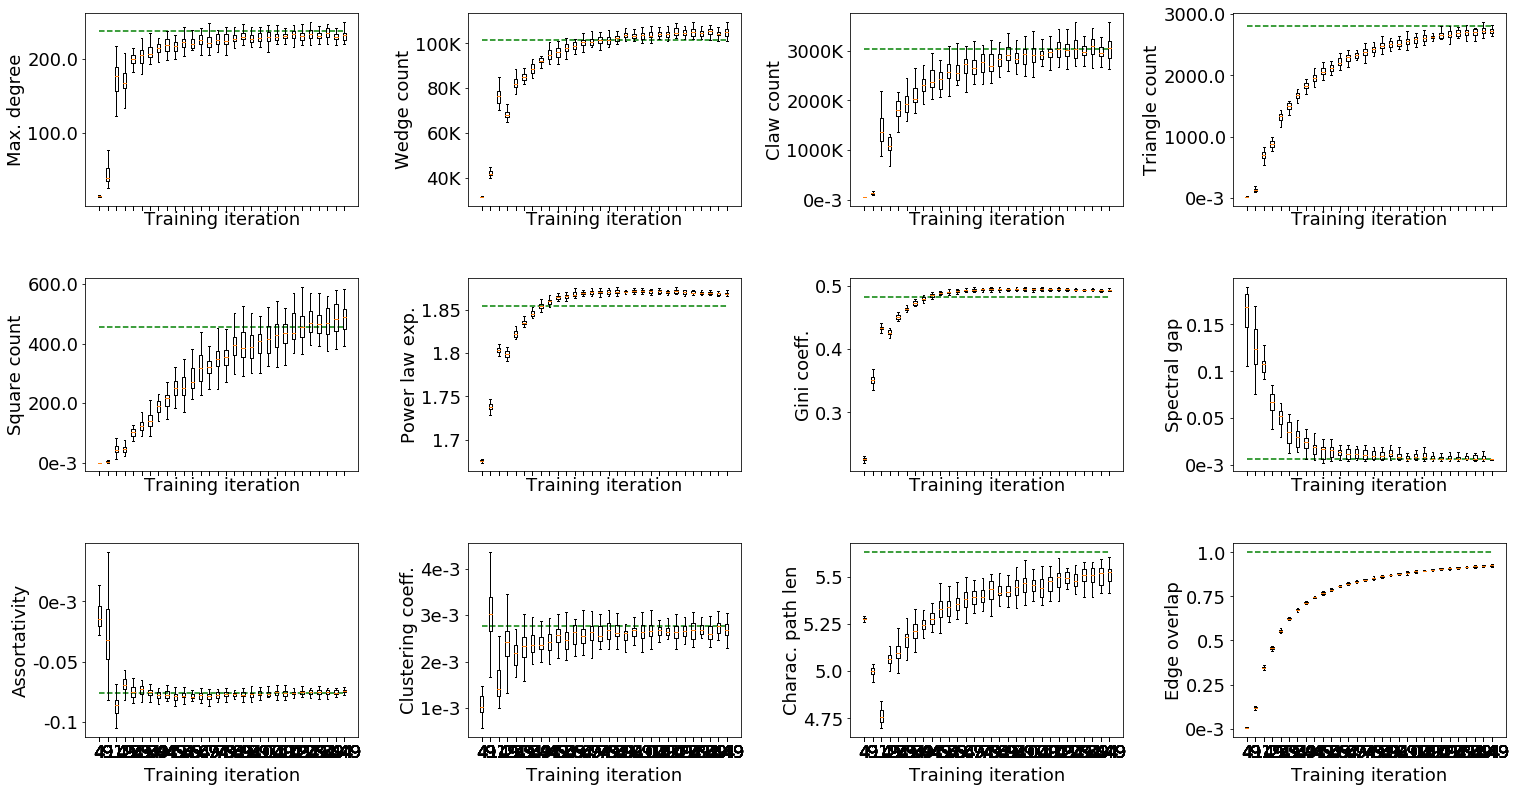

In [6]:
relevant_keys = ['d_max', 'wedge_count', 'claw_count', 'triangle_count', 'square_count',
                 'power_law_exp', 'gini', 'spectral_gap', 'assortativity', 'clustering_coefficient',
                 'cpl', 'overlap']

x = print_average_statistics(statistics_loggers=statistics_loggers,
                             statistics_train=statistics_train,
                             keys=relevant_keys)

# Same procedure with EO stopping criterion
Either take loggers from boxplots and search for corresponding entries with stopping criterion, or do pipeline again, but with EO stopper instead of loggers (=faster)

In [7]:
def main_with_EO(train_graph, H, EO_criterion, max_steps, optimizer_args, test_every, print_every):
    # Apply pipeline to generate a graph with our method
    E = train_graph.sum()
    W = train_graph.toarray()
    W /= W.sum()

    
    
    netmodel = net.NetWithoutSampling(W=W, H=H, 
                                      stoppers=[net.OverlapStopperWithoutSampling(train_graph=train_graph,
                                                                                  test_every=test_every)])

    netmodel.train(steps=max_steps,
                   optimizer_fn=torch.optim.Adam,
                   optimizer_args=optimizer_args,
                   EO_criterion=EO_criterion)

    transition_matrix = netmodel()

    scores_matrix = scores_matrix_from_transition_matrix(transition_matrix=transition_matrix,
                                                         symmetric=True)
    scores_matrix = sp.csr_matrix(scores_matrix)

    sampled_graph = utils.graph_from_scores(scores_matrix, train_graph.sum())
    EO_dict = utils.compute_graph_statistics(sampled_graph)
    EO_dict['overlap'] = utils.edge_overlap(train_graph.toarray(), sampled_graph)/E
    return sampled_graph, EO_dict

In [35]:
K = 20
EO_dicts = []
output_graphs = []

for k in range(K):
    print(f'Step {k}')
    sampled_graph, EO_dict = main_with_EO(train_graph=train_graph,
                                          H=12, EO_criterion=0.52, max_steps=50,
                                          optimizer_args={'lr' : 0.1, 'weight_decay' : 1e-7},
                                          test_every=5,
                                          print_every=50)
    EO_dicts.append(EO_dict)
    output_graphs.append(sampled_graph)
overlaps = get_overlap(output_graphs)

Step 0
Step: 4, Loss: 7.21666, Edge-Overlap: 0.009
Step: 9, Loss: 5.25442, Edge-Overlap: 0.114
Step: 14, Loss: 4.04989, Edge-Overlap: 0.349
Step: 19, Loss: 3.39791, Edge-Overlap: 0.458
Step: 24, Loss: 3.01779, Edge-Overlap: 0.548
Step 1
Step: 4, Loss: 7.23225, Edge-Overlap: 0.009
Step: 9, Loss: 5.32157, Edge-Overlap: 0.113
Step: 14, Loss: 4.12069, Edge-Overlap: 0.336
Step: 19, Loss: 3.43812, Edge-Overlap: 0.453
Step: 24, Loss: 3.03954, Edge-Overlap: 0.543
Step 2
Step: 4, Loss: 7.20805, Edge-Overlap: 0.008
Step: 9, Loss: 5.24267, Edge-Overlap: 0.126
Step: 14, Loss: 4.05147, Edge-Overlap: 0.358
Step: 19, Loss: 3.38174, Edge-Overlap: 0.473
Step: 24, Loss: 2.99242, Edge-Overlap: 0.552
Step 3
Step: 4, Loss: 7.22675, Edge-Overlap: 0.006
Step: 9, Loss: 5.29998, Edge-Overlap: 0.113
Step: 14, Loss: 4.07254, Edge-Overlap: 0.352
Step: 19, Loss: 3.39187, Edge-Overlap: 0.459
Step: 24, Loss: 2.99843, Edge-Overlap: 0.558
Step 4
Step: 4, Loss: 7.21612, Edge-Overlap: 0.006
Step: 9, Loss: 5.25439, Edge-

#### Saving and loading

In [36]:
pickle.dump([EO_dicts, overlaps], open("../data/EO_graphs.p", "wb"))

In [37]:
EO_dicts, overlaps = pickle.load(open("../data/EO_graphs.p", "rb"))

In [13]:
def EO_dict_of_lists_from_loggers(statistics_loggers, EO_criterion=0.52):
    EO_dict_of_lists = {}
    for statistics in statistics_loggers:
        EO_statistics = {}
        EO_step = np.argmax(np.array(statistics['overlap'])>EO_criterion)
        for key in statistics.keys():
            EO_statistics[key] = statistics[key][EO_step]
        EO_dict_of_lists = update_dict_of_lists(EO_dict_of_lists, EO_statistics)
    return EO_dict_of_lists

def EO_dict_of_lists_from_dicts(EO_dicts):
    EO_dict_of_lists = {}
    for dict_of_statistics in EO_dicts:
        EO_dict_of_lists = update_dict_of_lists(EO_dict_of_lists, dict_of_statistics)
    return EO_dict_of_lists

def get_average_statistics(EO_dict_of_lists):
    dict_of_average_statistics = {}
    for key in EO_dict_of_lists.keys():
        values = np.array(EO_dict_of_lists[key])
        dict_of_average_statistics[key] = (values.mean(), values.std())
    return dict_of_average_statistics
    
def print_table_of_average_statistics(list_of_average_statistics, keys, method_names):
    formatted_list_of_average_statistics = []
    # Convert (mean, std) into 'mean \pm std'
    for average_statistics in list_of_average_statistics:
        if type(average_statistics[keys[0]])==tuple:
            formatted_statistics = {}
            for key in average_statistics.keys():
                mean, std = average_statistics[key]
                formatted_statistics[key] = f'{round(mean,3)} \u00B1 {round(std,3)}'
        else:
            formatted_statistics = average_statistics
        formatted_list_of_average_statistics.append(formatted_statistics)
    df = pd.DataFrame(formatted_list_of_average_statistics, 
                      index=method_names)
    return df[keys]

#### From training with loggers (indirect)

In [10]:
EO_dict_of_lists = EO_dict_of_lists_from_loggers(statistics_loggers=statistics_loggers)
dict_of_average_statistics = get_average_statistics(EO_dict_of_lists=EO_dict_of_lists)
print_table_of_average_statistics(list_of_average_statistics=[statistics_train,
                                                              dict_of_average_statistics],
                                  keys=relevant_keys,
                                  method_names=['CORA-ML', 'Our method'])

,d_max,wedge_count,claw_count,triangle_count,square_count,power_law_exp,gini,spectral_gap,assortativity,clustering_coefficient,cpl,overlap
CORA-ML,238,101747,3.03351e+06,2802,457,1.85506,0.481863,0.00611441,-0.0762641,0.00277104,5.63001,1
Our method,199.767 ± 11.005,82257.967 ± 2466.634,1840570.0 ± 226235.564,1314.5 ± 68.598,103.3 ± 20.277,1.823 ± 0.004,0.451 ± 0.003,0.05 ± 0.011,-0.074 ± 0.007,0.002 ± 0.0,5.103 ± 0.054,0.554 ± 0.007


#### From training with stopping criterion (direct)

In [38]:
EO_dict_of_lists = EO_dict_of_lists_from_dicts(EO_dicts=EO_dicts)
dict_of_average_statistics = get_average_statistics(EO_dict_of_lists=EO_dict_of_lists)
print_table_of_average_statistics(list_of_average_statistics=[statistics_train,
                                                              dict_of_average_statistics],
                                  keys=relevant_keys,
                                  method_names=['CORA-ML', 'Our method'])

,d_max,wedge_count,claw_count,triangle_count,square_count,power_law_exp,gini,spectral_gap,assortativity,clustering_coefficient,cpl,overlap
CORA-ML,238,101747,3.03351e+06,2802,457,1.85506,0.481863,0.00611441,-0.0762641,0.00277104,5.63001,1
Our method,205.65 ± 11.297,83047.7 ± 2788.043,1950195.1 ± 251647.744,1346.9 ± 77.076,117.15 ± 25.794,1.823 ± 0.003,0.451 ± 0.002,0.043 ± 0.013,-0.072 ± 0.005,0.002 ± 0.0,5.094 ± 0.055,0.554 ± 0.007


# How large is the edge overlap between to output graphs at EO criterion?

In [28]:
def get_overlap(graphs):
    """ Computes average edge overlap between to graphs and the edge overlap between all graphs, relative to
        the total amount of edges."""
    m = len(graphs)
    E = graphs[0].sum()
    average_overlap = 0
    total_overlap = np.ones_like(graphs[0])
    for i in range(m):
        total_overlap *= graphs[i]
        for j in range(i+1, m):
            average_overlap += utils.edge_overlap(graphs[i], graphs[j]) / E
    average_overlap /= m * (m - 1) / 2 
    total_overlap = total_overlap.sum() / E
    return average_overlap, total_overlap

In [39]:
print(f'Average relative edge overlap between output graphs is {overlaps[0]:.3f}.')
print(f'Relative edge overlap between all output graphs is {overlaps[1]:.3f}.')

Average relative edge overlap between output graphs is 0.364.
Relative edge overlap between all output graphs is 0.031.
